In [1]:
# intel accelerator for sklearn
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# some basic packages
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

## Load the Data

In [6]:
# only load the transaction table
import os

transaction_path = os.path.join("data", "train_transaction.csv")
train_transaction = pd.read_csv(transaction_path)

In [7]:
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [14]:
# trying to understand the masked v_data
v_data = train_transaction.loc[:, train_transaction.columns.str.contains("V")]

In [24]:
# release the memory
del train_transaction

In [15]:
v_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 339 entries, V1 to V339
dtypes: float64(339)
memory usage: 1.5 GB


In [25]:
# impute missing values with -1
v_filled_n1 = v_data.fillna(-1)

In [26]:
v_filled_n1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 339 entries, V1 to V339
dtypes: float64(339)
memory usage: 1.5 GB


# Prepare with PCA

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# use the pipeline to create a transformer
transformer = Pipeline([
    ("std_trans", StandardScaler()),
    ("PCA_95", PCA(n_components=0.95)),
])

v_processed = transformer.fit_transform(v_filled_n1)

In [41]:
v_processed.size * v_processed.itemsize

236216000

In [42]:
transformer["PCA_95"].n_components_

50

# Prepare DataSet

In [47]:
# import the label
transaction_path = os.path.join("data", "train_transaction.csv")
train_transaction = pd.read_csv(transaction_path)
y = train_transaction['isFraud']
del train_transaction # release the space

In [48]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(v_processed, y)

# Try only train on the reduced V set

In [51]:
import xgboost as xgb

In [55]:
xgb_clf = xgb.XGBClassifier()

In [56]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [60]:
y_pred = xgb_clf.predict(X_test)

In [67]:
y_pred_proba = xgb_clf.predict_proba(X_test)

In [69]:
y_pred_proba = y_pred_proba[:,1]

In [70]:
y_pred_proba

array([0.00162709, 0.00213831, 0.01186629, ..., 0.00831896, 0.00424195,
       0.0251442 ], dtype=float32)

## Evaluate

In [59]:
y_test.value_counts() / len(y_test)

0    0.964988
1    0.035012
Name: isFraud, dtype: float64

In [57]:
# accuracy
xgb_clf.score(X_test, y_test)

0.9741186033122227

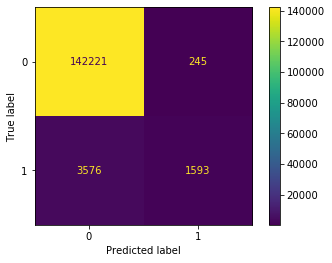

In [61]:
# Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(xgb_clf, X_test, y_test)

In [62]:
# precision and recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.8667029379760609, 0.3081834010446895)

In [79]:
# ROC AUC Score
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, y_pred_proba)
auc_score

0.8593712687485753

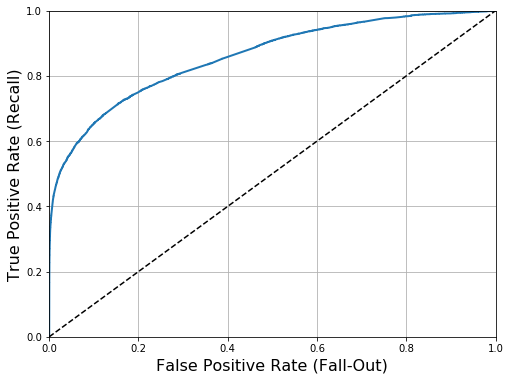

In [80]:
# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr, 'AUC = {:.2f}'.format(auc_score))
plt.show()